<a href="https://colab.research.google.com/github/etomaro/RL/blob/main/Grid_world_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class Agent():

    GAMMA = 0.9  # 割引率
    ACTIONS = ['right', 'up', 'left', 'down']
    # 移動の際に使う値
    act_dict = {
        'right': np.array([0,1]),
        'up': np.array([-1,0]),
        'left': np.array([0,-1]),
        'down': np.array([1,0])
    }
    # 方策(固定)
    pi_dict1 = {
        'right': 0.25,
        'up': 0.25,
        'left': 0.25,
        'down': 0.25
    }
    # 行動数
    num_action = len(ACTIONS)  # 4

    def __init__(self, array_or_list=np.array([0,0])):
        # listもnp.arrayでもいい
        if type(array_or_list) == list:
            array = np.array(array_or_list)
        else:
            array = array_or_list

        # 条件に当てはまらない場合エラーを返す
        assert (array[0] >= 0 and array[0] < 5 and \
                array[1] >= 0 and array[1] < 5)
 
        self.pos = array  # pos -> position


    # 現在位置を返す
    def get_pos(self):
        return self.pos
    
    # 現在位置をセットする
    def set_pos(self, array_or_list):
        # listもnp.arrayでもいい
        if type(array_or_list) == list:
            array = np.array(array_or_list)
        else:
            array = array_or_list

        # 条件に当てはまらない場合エラーを返す
        assert (array[0] >= 0 and array[0] < 5 and \
                array[1] >= 0 and array[1] < 5)
 
        self.pos = array  # pos -> position

    # 現在位置から移動
    def move(self, action):
        """
        - A - B -
        - - - - -
        - - - b -
        - - - - -
        - a - - -
        """
        # 移動量を取得
        move_coord = self.act_dict[action].copy()
    
        # A地点
        if (self.get_pos() == np.array([0,1])).all():
            pos_new = [4,1]  # a地点
        elif (self.get_pos() == np.array([0,3])).all():
            pos_new = [2,3]  # b地点
        else:
            pos_new = self.get_pos() + move_coord 
        
        # グリッドの外に出た場合の処理(出ないようにする)
        pos_new[0] = np.clip(pos_new[0], 0, 4)  # 0未満なら0に。4より上なら4に
        pos_new[1] = np.clip(pos_new[1], 0, 4)
        self.set_pos(pos_new)

    # 現在位置から移動することによる報酬。この関数では移動自体は行わない
    def reward(self, state, action):
        # A地点
        if (state == np.array([0,1])).all():
            r = 10
            return r
        # B地点
        if (state == np.array([0,3])).all():
            r = 5
            return r
        
        # グリッドの外に行く場合は罰則
        if state[0] == 0 and action == 'up':
            r = -1
        elif state[0] == 4 and action == 'down':
            r = -1
        elif state[1] == 0 and action == 'left':
            r = -1
        elif state[1] == 4 and action == 'right':
            r = -1
        else:
            r = 0

        return r
 
    # 方策(π)
    def pi(self, state, action):
        # 変数にstateを持っているが、今回は方策はstateに依存しない
        return self.pi_dict1[action]
    
    # 状態価値関数の算出
    def V_pi(self, state, n, out, iter_num):
        """
        state: 関数呼び出した時の状態
        out: 戻り値用。関数実行時は0を指定。※この引数を消してresult=0としてやった場合変わるかどうかテストする。
        n: 再帰関数の呼び出し回数が何回目か。最初の呼び出しは1
        iter_num: 再帰関数を何回呼び出す予定か。
        """
        self.set_pos(state)
        
        if n == iter_num:  # 末端状態
            for action in self.ACTIONS:
                out += self.pi(state, action) * self.reward(state, action)
            return out
        else:
            for action in self.ACTIONS:
                out += self.pi(state, action) * self.reward(state, action)
                # 次の状態に遷移
                self.move(action)

                # 再帰
                out += self.pi(self.get_pos(), action) * \
                       self.V_pi(self.get_pos(), n+1, 0, iter_num) * self.GAMMA

                # stateを関数(または再帰関数)呼び出し時に戻す
                self.set_pos(state)

            return out

    # 全てのstateでの状態価値関数を算出
    def V_pi_all(self, n, out, iter_num):
        """
        argのstateは全てのstateでの価値を算出するので必要ない
        [[x=0の値], [x=1の値], ... [x=4の値]]

        戻り値
          V_pi_all[2][3] -> (2,3)での状態価値
        """
        grid_pos_array = np.array([
            [0,0], [0,1], [0,2], [0,3], [0,4],
            [1,0], [1,1], [1,2], [1,3], [1,4],
            [2,0], [2,1], [2,2], [2,3], [2,4],
            [3,0], [3,1], [3,2], [3,3], [3,4],
            [4,0], [4,1], [4,2], [4,3], [4,4]
        ])

        # 戻り値を初期化
        result_V_all = np.zeros(shape=(5,5))

        # ループで5*5回Vを求めていく
        for pos in grid_pos_array:
            x = pos[0]
            y = pos[1]

            tmp_V = self.V_pi(
                state=pos,
                n=1,
                out=0,
                iter_num=iter_num
            )
            
            # 結果を挿入
            result_V_all[x][y] = tmp_V
        
        return result_V_all
        

    # 行動価値関数の算出
    def Q_pi(self, state, action, n, out, iter_num):

        if n==iter_num:
            out += self.pi(state, action) * self.reward(state, action)
            return out
        else:
            out += self.reward(state, action)
            self.set_pos(state)  # これなぜか必要。結果が変わった
            self.move(action)

            state_before_recursion = self.get_pos()

            # 再帰関数
            for next_action in self.ACTIONS:
                out += self.pi(state_before_recursion, next_action) * \
                       self.Q_pi(state_before_recursion, next_action, n+1, 0, iter_num) * self.GAMMA
                self.set_pos(state)
            return out
    
    def Q_pi_all(self, n, out, iter_num):
        """
        [
            [   # x=0の時
                [rightの値, upの値, leftの値, downの値], [], [], [], [],
            ],
            .
            .
        ]
        """
        grid_pos_array = np.array([
            [0,0], [0,1], [0,2], [0,3], [0,4],
            [1,0], [1,1], [1,2], [1,3], [1,4],
            [2,0], [2,1], [2,2], [2,3], [2,4],
            [3,0], [3,1], [3,2], [3,3], [3,4],
            [4,0], [4,1], [4,2], [4,3], [4,4]
        ])

        # 戻り値を初期化
        result_Q_all = np.zeros(shape=(5,5,4))

        # ループで5*5回Vを求めていく
        for pos in grid_pos_array:
            x = pos[0]
            y = pos[1]

            # アクションごとにQ値を求める
            tmp_Q_list = np.array([])
            for action in self.ACTIONS:
                tmp_Q = self.Q_pi(
                    state=pos,
                    action= action,
                    n=1,
                    out=0,
                    iter_num=iter_num
                )
                tmp_Q_list = np.append(tmp_Q_list, tmp_Q)
            # 結果を挿入
            result_Q_all[x][y] = tmp_Q_list
        
        return result_Q_all

    def V_value_plot(self, V):
        """

        """
        ax = plt.gca()  # グラフの素を生成
        plt.xlim(0,5)
        plt.ylim(0,5)  # 0 - 5まで
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])  # x,y軸の数値を消す(表示しない)
        v_array_round = np.round(V, decimals=2)
        # x=j, y=i 
        for i in range(5):
            for j in range(5):
                # rect
                rect = plt.Rectangle(xy=(i,j), width=1, height=1, fill=False)  # 四角形を生成。生成。xy:左下の座標。
                ax.add_patch(rect)
                # 座標のインデックスの調整
                x, y = self.pltToGrid(i, j)   # plot用の座標からグリッド用の座標に変換
        
                # text 
                plt.text(i+0.4, j+0.5, v_array_round[int(x)][int(y)])  # 図の真ん中にテキストを表示させる

    def pltToGrid(self, x, y):
        """
        plot用は左下から座標を決めている
        GridWorldでは左上から座標を決めている
        """
        pltToGrid = {
            '0-4':'0-0', '1-4':'0-1', '2-4':'0-2', '3-4':'0-3', '4-4':'0-4',
            '0-3':'1-0', '1-3':'1-1', '2-3':'1-2', '3-3':'1-3', '4-3':'1-4',
            '0-2':'2-0', '1-2':'2-1', '2-2':'2-2', '3-2':'2-3', '4-2':'2-4',
            '0-1':'3-0', '1-1':'3-1', '2-1':'3-2', '3-1':'3-3', '4-1':'3-4',
            '0-0':'4-0', '1-0':'4-1', '2-0':'4-2', '3-0':'4-3', '4-0':'4-4'
        }
        input = str(x) + '-' + str(y)  #a 入力データを加工
        output = pltToGrid[input]

        # 置換
        xy = output.split('-')
        result_x, result_y = xy[0], xy[1]
        
        return result_x, result_y

In [ ]:
# 全ての状態価値関数の算出
"""
値を再計算する場合は「V_all_〇〇.npy」ファイルを削除する必要あり

処理時間
  iter_num:10 -> 17:03(1038s)
"""
import time
import os

agent = Agent()

# 計算するステップ数
iter_num = 10

_filepath = f'./V_all_{str(iter_num)}.npy'
is_file = os.path.isfile(_filepath)
if is_file:
    load_V = np.load(_filepath)
    print(load_V)
    
    # plot
    agent.V_value_plot(load_V)
else:
    start = time.time()
    # 算出
    V_all = agent.V_pi_all(
        n=1, out=0, iter_num=iter_num
    )
    print('処理時間: ', time.time()-start, '\n')

    # ファイル作成
    np.save(_filepath, V_all)
    print('fileを作成しました')
    
    # 出力
    print("V_all\n", V_all)


処理時間:  904.3000273704529 

fileを作成しました
V_all
 [[ 3.33832439  8.9072904   4.4381291   5.30100667  1.38491751]
 [ 1.49866649  3.00064994  2.21804135  1.84992266  0.45645284]
 [ 0.03421955  0.7215252   0.6720092   0.33279551 -0.42711549]
 [-0.94101406 -0.38258473 -0.31018898 -0.51712397 -1.11986174]
 [-1.76685177 -1.25011029 -1.11464591 -1.30133226 -1.84070463]]


In [ ]:
import numpy as np

a = np.zeros(shape=(5,5,4))
a[0][1] = [1,1,1,1]
print(a)



[[[0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [ ]:
# 全ての行動価値関数の算出
"""
値を再計算する場合は「Q_all_〇〇.npy」ファイルを削除する必要あり

処理時間
  # iter_num:10 -> 17:03(1038s)
"""
import time
import os

agent = Agent()

# 計算するステップ数
iter_num = 10

_filepath = f'./Q_all_{str(iter_num)}.npy'
is_file = os.path.isfile(_filepath)
if is_file:
    load_Q = np.load(_filepath)
    print(load_Q)
    
    # plot
    # agent.V_value_plot(load_V)
else:
    start = time.time()
    # 算出
    Q_all = agent.Q_pi_all(
        n=1, out=0, iter_num=iter_num
    )
    print('処理時間: ', time.time()-start, '\n')

    # ファイル作成
    np.save(_filepath, Q_all)
    print('fileを作成しました')
    
    # 出力
    print("Q_all\n", Q_all)


処理時間:  982.5281083583832 

fileを作成しました
Q_all
 [[[ 8.08123982  1.97710769  1.97710769  1.28384826]
  [ 8.92698701  8.92698701  8.92698701  8.92698701]
  [ 4.73698927  2.98259166  8.08123982  1.94830497]
  [ 5.26907756  5.26907756  5.26907756  5.26907756]
  [ 0.17374574  0.17374574  4.73698927  0.34612865]]

 [[ 2.67174965  2.97710769  0.28384826 -0.01899635]
  [ 1.94830497  8.08123982  1.28384826  0.609671  ]
  [ 1.61093887  3.98259166  2.67174965  0.57419131]
  [ 0.34612865  4.73698927  1.94830497  0.26907756]
  [-0.65387135  1.17374574  1.61093887 -0.4088142 ]]

 [[ 0.609671    1.28384826 -1.01899635 -0.84318615]
  [ 0.57419131  2.67174965 -0.01899635 -0.33388406]
  [ 0.26907756  1.94830497  0.609671   -0.26514814]
  [-0.4088142   1.61093887  0.57419131 -0.44016489]
  [-1.4088142   0.34612865  0.26907756 -0.97595222]]

 [[-0.33388406 -0.01899635 -1.84318615 -1.53904886]
  [-0.26514814  0.609671   -0.84318615 -1.07301299]
  [-0.44016489  0.57419131 -0.33388406 -0.9465297 ]
  [-0.975952

In [ ]:
# テスト
# ------Agent------
agent = Agent(np.array([0,0]))

# 1 get_pos()のテスト
now_pos = agent.get_pos()
print("1 get_pos()のテストのテスト\nnow_pos: ", now_pos, "\n")

# 2 set_pos()のテスト
agent.set_pos(np.array([3,3]))
print("2 set_pos()のテスト\nnow_pos: ", agent.get_pos(), "\n")

# 3.1 move()のテスト (3,3) -> (2,3)
agent.move("up")
print("3.1 move()のテスト\nnow_pos: ", agent.get_pos(), "\n")

# 3.2 move()のテスト (4,4) -> right -> (4,4)
agent.set_pos(np.array([4,4]))
agent.move("right")
print("3.2 move()のテスト\nnow_pos: ", agent.get_pos(), "\n")

# 4.1 A地点からアクションした際の報酬と次の状態
agent.set_pos(np.array([0,1]))
reward = agent.reward(agent.get_pos(), "up")
agent.move("up")
print("4.1 A地点からアクションした際の報酬と次の状態\nreward: ", reward, "\nnow_pos: ", agent.get_pos(), "\n")

# 4.2 B地点からアクションした際の報酬と次の状態
agent.set_pos(np.array([0,3]))
reward = agent.reward(agent.get_pos(), "right")
agent.move("right")
print("4.2 B地点からアクションした際の報酬と次の状態\nreward: ", reward, "\nnow_pos: ", agent.get_pos(), "\n")

# 4.3 (4,4)からrightした時の報酬
agent.set_pos(np.array([4,4]))
reward = agent.reward(agent.get_pos(), "right")
agent.move("right")
print("4.3 (4,4)からrightした時の報酬報酬\nreward: ", reward, "\nnow_pos: ", agent.get_pos(), "\n")




1 get_pos()のテストのテスト
now_pos:  [0 0] 

2 set_pos()のテスト
now_pos:  [3 3] 

3.1 move()のテスト
now_pos:  [2 3] 

3.2 move()のテスト
now_pos:  [4 4] 

4.1 A地点からアクションした際の報酬と次の状態
reward:  10 
now_pos:  [4 1] 

4.2 B地点からアクションした際の報酬と次の状態
reward:  5 
now_pos:  [2 3] 

4.3 (4,4)からrightした時の報酬報酬
reward:  -1 
now_pos:  [4 4] 



In [24]:
# 12時間ルールの残り時間の確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'

# 割り当てられた割り当てられたGPUの確認
!nvidia-smi


残り時間 : 10.68NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# (0,0)地点での状態価値関数の算出
"""
iter=10の時の時
10回行動した時まで考える。
考慮する状態のパターンは4**10(104万8576)
再帰関数を呼ぶ(実行する)回数は回数は9回。関数自体は10回。

計算結果
  iter_num:11 -> 3.34
                (0,1)8.87
                (4,4)-1.87
計算速度の結果
  iter_num: 2 -> 0.0008s
  iter_num: 5 -> 0.17s  
  iter_num:10 -> 37s
  iter_num:11 -> 163s
"""
import time 


agent = Agent()

start = time.time()  # 計測開始
v00 = agent.V_pi(
    state=np.array([4,4]),
    n=1,
    out=0,
    iter_num=11
)
time_result = time.time() - start  # 計測終了

print("v00: ", v00)
print("計測時間: ", time_result)

KeyboardInterrupt: ignored

In [ ]:
# (0,0)での行動価値
"""
結果
  iter_num: 9 -> [8.641357421875, 3.187145233154297, 3.187145233154297, 2.095439910888672]
  iter_num:10 -> [8.52474594116211, 3.2777719497680664, 3.2777719497680664, 2.2374868392944336]
  iter_num:11 -> [8.401861190795898, 3.329444169998169, 3.329444169998169, 2.359862804412842]
処理時間
  iter_num: 9 -> 12
  iter_num:10 -> 50s
  iter_num:11 -> 178s
"""

import time

agent = Agent()
start = time.time()

q00 = []
actions = ['right', 'up', 'left', 'down']
for i, action in enumerate(actions):
    q00_tmp = agent.Q_pi(
        state=np.array([0,0]),
        action=action,
        n=1,
        out=0,
        iter_num=9
    )
    q00.append(q00_tmp)
time_result = time.time() - start

print("q00", q00)
print("計測時間: ", time_result)

q00 [8.129917148312988, 1.938732374972039, 1.938732374972039, 1.2242078128629685]
計測時間:  11.417083501815796


In [ ]:
# fileの作成のテスト
import os
import numpy as np


# ------通常ファイル------
# fileの作成
_filepath = './test.txt'
filecontents = """
1 aiu
2 eo
3 kakiku
4 keko
"""

# 書き込み
# fileが存在しない場合のみ実行する。これがないと同じファイル名で毎度上書きされる
is_file = os.path.isfile(_filepath)
if is_file:
    print('同じ名前のfileが既に存在します')
else:
    with open(_filepath, 'w') as f:
        f.write(filecontents)
    print('fileを作成しました')

# ファイルの読み込み
with open(_filepath, 'r') as f:
    print(f.read())


# ------numpyファイル------
# numpy.arrayのタイプを確認 -> numpy.ndarray
num_type = np.array([1,2,3])
print(type(num_type))

# file(numpy.array)の作成
_filepath_num = 'test.npy'
filecontents_num = np.array([1,2,3,4,5])

# 書き込み
is_file_num = os.path.isfile(_filepath_num)
if is_file_num:
    print('既にnpファイルは存在しています')
else:
    np.save(_filepath_num, filecontents_num)
    print('npファイルを作成しました')

# 読み込み
load_num = np.load(_filepath_num)
print(load_num)
print(type(load_num))





fileを作成しました

1 aiu
2 eo
3 kakiku
4 keko

<class 'numpy.ndarray'>
既にnpファイルは存在しています
[1 2 3 4 5]
<class 'numpy.ndarray'>


In [ ]:
# numpyテスト
import numpy as np 

# 型のテスト
array = np.array([1,2,3])
print('array: ', array, '\n', 'arrayのタイプ: ', type(array), '\n')

array_multi = np.array([[1,2,3], [4,5,6], [7,8,9]])
print('array_multi: ', array_multi, '\n', 'array_multiのタイプ', type(array_multi), '\n')
print('array_multi[0]のタイプ: ', type(array_multi[0]), '\n')

# 追加
array = np.array([1,2])
array_new = np.append(array, 3)
print('array: ', array, '\n', 'array_new: ', array_new, '\n')

array_multi = np.array([[1,2], [3,4]])
array_multi_new = np.append(array_multi, [5,6])
print('array_multi: ', array_multi, '\n', 'array_multi_new', array_multi_new, '\n')

# 2次元配列の追加(axis=0, 追加先と追加する次元が一致する必要あり, 追加する値はnp.array()する必要なくリストでいい)
array_multi2 = np.array([[1,2], [3,4]])
array_multi2_new = np.append(array_multi2, [[5,6]], axis=0)
print('array_multi2: ', array_multi2, "\n", 'array_multi2_new: ', array_multi2_new, '\n')
print('array_multi2_new[0]のタイプ: ', type(array_multi2_new[0]), '\n', 'array_muulti2_new[2]のタイプ', type(array_multi2_new[2]), '\n')

# list->numpy
list1 = [1,2,3]
array1 = np.array(list1)
print("------list->numpyのテスト------")
print('list1:', list1, '\n', 'array1: ', array1)
print('list1のタイプ: ', type(list1), '\n', 'array1のタイプ: ', type(array1), '\n')

list2 = [[1,2], [3,4]]
array2 = np.array(list2)
print('list2:', list2, '\n', 'array2: ', array2)
print('list2のタイプ: ', type(list2), '\n', 'array2のタイプ: ', type(array2))

array:  [1 2 3] 
 arrayのタイプ:  <class 'numpy.ndarray'> 

array_multi:  [[1 2 3]
 [4 5 6]
 [7 8 9]] 
 array_multiのタイプ <class 'numpy.ndarray'> 

array_multi[0]のタイプ:  <class 'numpy.ndarray'> 

array:  [1 2] 
 array_new:  [1 2 3] 

array_multi:  [[1 2]
 [3 4]] 
 array_multi_new [1 2 3 4 5 6] 

array_multi2:  [[1 2]
 [3 4]] 
 array_multi2_new:  [[1 2]
 [3 4]
 [5 6]] 

array_multi2_new[0]のタイプ:  <class 'numpy.ndarray'> 
 array_muulti2_new[2]のタイプ <class 'numpy.ndarray'> 

------list->numpyのテスト------
list1: [1, 2, 3] 
 array1:  [1 2 3]
list1のタイプ:  <class 'list'> 
 array1のタイプ:  <class 'numpy.ndarray'> 

list2: [[1, 2], [3, 4]] 
 array2:  [[1 2]
 [3 4]]
list2のタイプ:  <class 'list'> 
 array2のタイプ:  <class 'numpy.ndarray'>


In [ ]:
a = [[]]
a.append([[9]])

print(a)


[[], [[9]]]


In [ ]:
import numpy as np

result = np.zeros(shape=(5,5))
print(result)
result[2][3] = 1
print(result)

a = np.array([[1,2], [3,4], [5,6]])
for i in a:
    print(i)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[1 2]
[3 4]
[5 6]


In [ ]:
ai = 44
print(f'kakikuke{str(ai)}ko')

kakikuke44ko


In [ ]:
# クラスメソッド
class A():
    def a():
        print('クラスメソッドが呼ばれました')

print(A.a())
try:
    a = A()
    print(a.a())
except Exception:
    print('エラーが発生しました')

クラスメソッドが呼ばれました
None
エラーが発生しました


matplotlib基本的な使い方


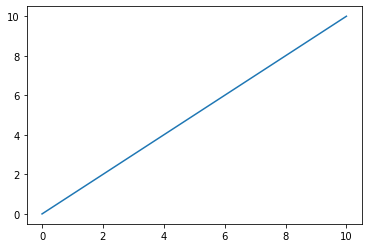

np.roundのテスト
[0. 0. 0. 1. 1. 2. 2. 2. 2. 3.]


In [ ]:
# matplotlibのテスト
import matplotlib.pyplot as plt
import numpy as np


# ------matplotlib基本的な使い方------
print('matplotlib基本的な使い方')
x = np.linspace(0, 10, 100)  # 0-10までの数字を100分割する(xに使う(not f(x)))
y = x  # y=x
plt.plot(x, y)
plt.show()
# ----------------------------------

# plt.gca() -> 現在のplt情報を取得

# plt.xlim, ylim  -> x,yの表示範囲

# set_ticklabels([])  ->  x軸, y軸のいらないところを消す

# np.round(x,decimals=2) -> # xの値を少数第2位までにする(少数第3位で偶数丸めする)
"""
偶数丸めとは
 端数<5  切り捨て
 端数=5  結果が偶数になる方にする
 端数>5  切り上げ

四捨五入の際に5を切り上げしてしまうと、切り上げの割合が多くなり結果の値が大きくなる傾向があるため
偶数丸めが使用される
"""
print('np.roundのテスト')
a = [0.1,0.4,0.5,0.6,1.4,1.5,1.6,2.4,2.5,2.6]
b = np.round(a, decimals=0)
print(b)

# plt.Rectangleとadd_patch() -> 四角形の図形を生成する。add_patch()でRectanbleで生成した図型を反映する

# plt.text  ->  グラフ内にテキストを表示する

Text(0.55, 0.55, 'aiu')

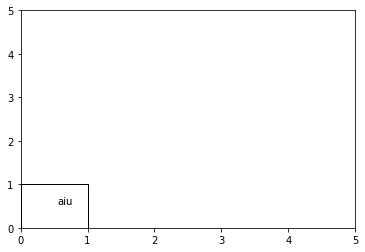

In [ ]:
import matplotlib.pyplot as plt 
ax = plt.gca()
plt.xlim(0,5)
plt.ylim(0,5)
# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])

rect = plt.Rectangle(xy=(0,0), width=1, height=1, fill=False)
ax.add_patch(rect)
plt.text(0.55,0.55,"aiu")

In [ ]:
a = 'ai-ue'
print(a.split('-'))

['ai', 'ue']


In [ ]:
a = [[0,0], [0,0]]
a[0][0] = [1,2,3]
print(a)

[[[1, 2, 3], 0], [0, 0]]


In [ ]:
import numpy as np

np.arange